In [1]:
!pip install tensorflow numpy matplotlib

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class HeatTransferPINN:
    def __init__(self, layers, alpha, lb, ub):
        """
        Initialize the PINN model.

        Parameters:
        - layers: List containing the number of neurons in each layer.
        - alpha: Thermal diffusivity.
        - lb: Lower bound of the domain (t, x).
        - ub: Upper bound of the domain (t, x).
        """
        self.alpha = alpha
        self.lb = lb
        self.ub = ub
        self.model = self.build_model(layers)

    def build_model(self, layers):
        """
        Builds a feedforward neural network.

        Parameters:
        - layers: List containing the number of neurons in each layer.

        Returns:
        - model: A TensorFlow Keras Sequential model.
        """
        model = tf.keras.Sequential()
        for width in layers[:-1]:
            model.add(tf.keras.layers.Dense(width, activation='tanh'))
        model.add(tf.keras.layers.Dense(layers[-1], activation=None))
        return model

    def pdb_t(self, t, x):
        """
        Computes the PDE residual for the heat equation.

        Parameters:
        - t: Tensor containing time coordinates.
        - x: Tensor containing spatial coordinates.

        Returns:
        - residual: Tensor representing the residual of the PDE.
        """
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([t, x])
            T = self.model(tf.concat([t, x], axis=1))
            T_t = tape.gradient(T, t)
            T_x = tape.gradient(T, x)
        T_xx = tape.gradient(T_x, x)
        del tape
        residual = T_t - self.alpha * T_xx
        return residual

    def loss_function(self, t, x, T_true, t_bc, x_bc, T_bc, t_ini, x_ini, T_ini):
        """
        Computes the total loss combining PDE residual, boundary, and initial conditions.

        Parameters:
        - t, x: Tensors for collocation points in the domain.
        - T_true: Tensor for true temperature values at collocation points.
        - t_bc, x_bc, T_bc: Boundary condition tensors.
        - t_ini, x_ini, T_ini: Initial condition tensors.

        Returns:
        - total_loss: Scalar tensor representing the total loss.
        """
        # PDE residual
        f = self.pdb_t(t, x)
        mse_pde = tf.reduce_mean(tf.square(f))

        # Boundary conditions
        T_pred_bc = self.model(tf.concat([t_bc, x_bc], axis=1))
        mse_bc = tf.reduce_mean(tf.square(T_pred_bc - T_bc))

        # Initial conditions
        T_pred_ini = self.model(tf.concat([t_ini, x_ini], axis=1))
        mse_ini = tf.reduce_mean(tf.square(T_pred_ini - T_ini))

        # Total loss
        total_loss = mse_pde + mse_bc + mse_ini
        return total_loss

    def train(self, optimizer, epochs, t, x, T_true, t_bc, x_bc, T_bc, t_ini, x_ini, T_ini):
        """
        Trains the PINN model.

        Parameters:
        - optimizer: TensorFlow optimizer instance.
        - epochs: Number of training epochs.
        - t, x, T_true: Collocation points and true temperature.
        - t_bc, x_bc, T_bc: Boundary condition tensors.
        - t_ini, x_ini, T_ini: Initial condition tensors.
        """
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                loss = self.loss_function(t, x, T_true, t_bc, x_bc, T_bc, t_ini, x_ini, T_ini)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            if epoch % 1000 == 0:
                print(f'Epoch {epoch}, Loss: {loss.numpy()}')

In [2]:
# Define parameters
alpha = 0.01  # Thermal diffusivity
layers = [2, 20, 20, 20, 1]  # Neural network layers
lb = np.array([0, 0])  # Lower bound for t and x
ub = np.array([1, 1])  # Upper bound for t and x

# Initialize PINN
pinn = HeatTransferPINN(layers, alpha, lb, ub)

# Generate collocation points
N_f = 10000  # Number of collocation points
t_f = np.random.uniform(lb[0], ub[0], (N_f, 1))
x_f = np.random.uniform(lb[1], ub[1], (N_f, 1))

# Generate boundary condition points (e.g., x=0 and x=1 for all t)
N_bc = 200
t_bc = np.random.uniform(lb[0], ub[0], (N_bc//2, 1))
x_bc_0 = np.zeros((N_bc//2, 1))
x_bc_1 = np.ones((N_bc//2, 1))
t_bc = np.vstack([t_bc, t_bc])
x_bc = np.vstack([x_bc_0, x_bc_1])
# Define boundary temperature (e.g., T=0)
T_bc = np.zeros((N_bc, 1))

# Generate initial condition points (t=0 for all x)
N_ini = 200
x_ini = np.random.uniform(lb[1], ub[1], (N_ini,1))
t_ini = np.zeros((N_ini,1))
# Define initial temperature distribution (e.g., T=sin(pi*x))
T_ini = np.sin(np.pi * x_ini)

# Convert all data to TensorFlow tensors
t_f = tf.convert_to_tensor(t_f, dtype=tf.float32)
x_f = tf.convert_to_tensor(x_f, dtype=tf.float32)

t_bc = tf.convert_to_tensor(t_bc, dtype=tf.float32)
x_bc = tf.convert_to_tensor(x_bc, dtype=tf.float32)
T_bc = tf.convert_to_tensor(T_bc, dtype=tf.float32)

t_ini = tf.convert_to_tensor(t_ini, dtype=tf.float32)
x_ini = tf.convert_to_tensor(x_ini, dtype=tf.float32)
T_ini = tf.convert_to_tensor(T_ini, dtype=tf.float32)

In [6]:
# Training the model
# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Train the model
epochs = 10000
pinn.train(optimizer, epochs, t_f, x_f, None, t_bc, x_bc, T_bc, t_ini, x_ini, T_ini)

Epoch 0, Loss: 1.3031725757173263e-05
Epoch 1000, Loss: 4.385628926684149e-06
Epoch 2000, Loss: 2.753785338427406e-06
Epoch 3000, Loss: 2.405924760751077e-06
Epoch 4000, Loss: 2.4172204575734213e-06
Epoch 5000, Loss: 1.9405455532250926e-05
Epoch 6000, Loss: 1.9470598999760114e-06
Epoch 7000, Loss: 2.368327159274486e-06
Epoch 8000, Loss: 1.837123363657156e-06
Epoch 9000, Loss: 1.8036196252069203e-06


<ipython-input-7-5f426f526fbb>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_pred[i,j] = T_p.numpy()


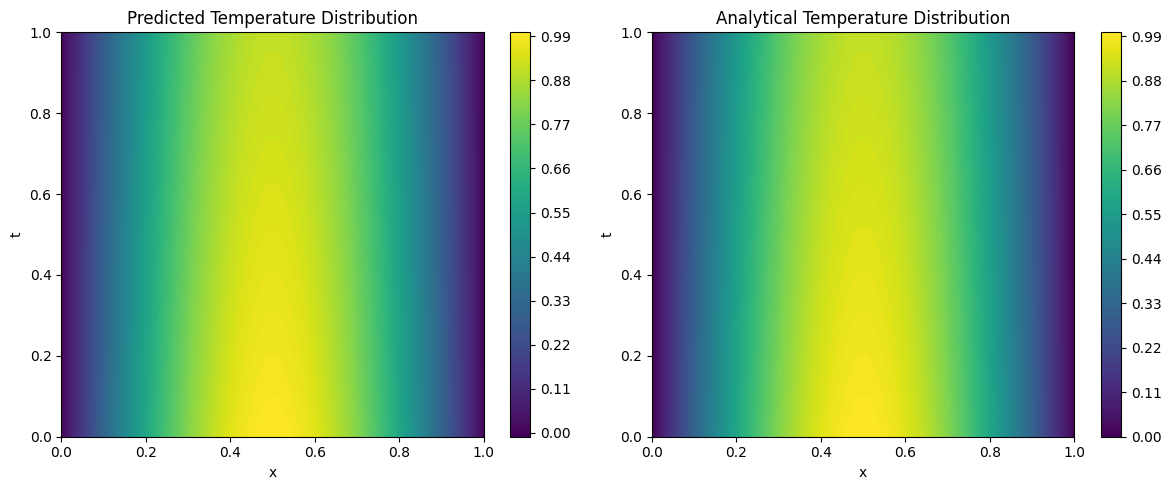

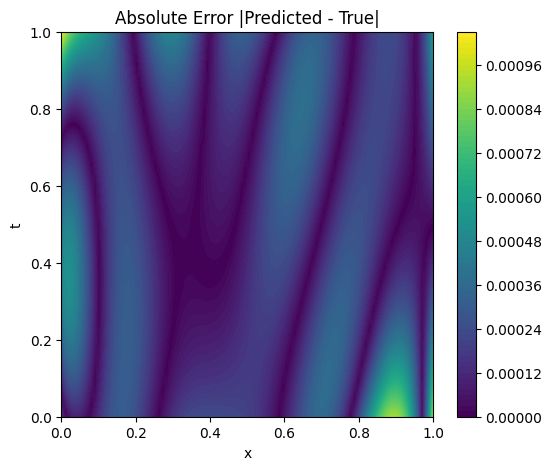

In [7]:
# Evaluating the model
# Define the analytical solution for comparison
def analytical_solution(t, x, alpha):
    return np.exp(- (np.pi**2) * alpha * t) * np.sin(np.pi * x)

# Generate a grid for evaluation
t_star = np.linspace(lb[0], ub[0], 100)
x_star = np.linspace(lb[1], ub[1], 100)
T_pred = np.zeros((len(t_star), len(x_star)))
T_true = np.zeros((len(t_star), len(x_star)))

for i in range(len(t_star)):
    for j in range(len(x_star)):
        t_input = tf.convert_to_tensor([[t_star[i], x_star[j]]], dtype=tf.float32)
        T_p = pinn.model(t_input)
        T_pred[i,j] = T_p.numpy()
        T_true[i,j] = analytical_solution(t_star[i], x_star[j], alpha)

# Plot the results
X, T = np.meshgrid(x_star, t_star)

plt.figure(figsize=(12, 5))

# Predicted Temperature
plt.subplot(1, 2, 1)
plt.contourf(X, T, T_pred, 100, cmap='viridis')
plt.colorbar()
plt.title('Predicted Temperature Distribution')
plt.xlabel('x')
plt.ylabel('t')

# Analytical Temperature
plt.subplot(1, 2, 2)
plt.contourf(X, T, T_true, 100, cmap='viridis')
plt.colorbar()
plt.title('Analytical Temperature Distribution')
plt.xlabel('x')
plt.ylabel('t')

plt.tight_layout()
plt.show()

# Compute and plot the error
error = np.abs(T_pred - T_true)

plt.figure(figsize=(6,5))
plt.contourf(X, T, error, 100, cmap='viridis')
plt.colorbar()
plt.title('Absolute Error |Predicted - True|')
plt.xlabel('x')
plt.ylabel('t')
plt.show()